In [1]:
import edit.training
import edit.pipeline
import edit.data

In [2]:
import os
os.environ['EDIT_MODELS_ASSETS'] = '/g/data/ra02/.edit/models/assets/'

## Inference with SFNO
While SFNO is wrapped in an `edit.model` to make it easier to use, we are going to pull it apart to show each step, and how its configured. 

Firstly though, let's look at it's `edit.model`...

## edit.models

In [3]:
import edit.models

In [4]:
'Global/sfno' in edit.models.Models

True

In [5]:
edit.models.Models['Global/sfno']

sfno.registered_model.SFNO

This is an `edit.model` call, which can be given interactively, 

But lets unpack them:
- We shall specify the source of data we want to use, 'ERA5'
- Where we want to save the data, 'temp' auto creates a temporary directory
- And finally the lead time, '1 day'

Then to show the doc string `?` is used

In [6]:
edit_model_sfno = edit.models.Models['Global/sfno'](pipeline = 'ERA5', output = 'temp', lead_time = '1 day')
edit_model_sfno?

Signature:      edit_model_sfno(*args, **kwargs)
Type:           SFNO
String form:   
`edit.models` Forecast model

Model Name:          'Global/sfno'
Data Source:         'ERA5'
Output Directory:    'temp'
File:           /g/data/eu56/hc7988/Projects/EDIT/models/EarthSystem/sfno/src/sfno/registered_model.py
Docstring:     
FourCastNetv2 Model

- Spherical Fourier Neural Operators: Learning Stable Dynamics on the Sphere
    by Boris Bonev, Thorsten Kurth, Christian Hundt, Jaideep Pathak, Maximilian Baust, Karthik Kashinath, Anima Anandkumar
- https://github.com/NVIDIA/torch-harmonics

Developed by NVIDIA.


Arguments:
    lead_time (int | str | edit.data.TimeDelta): 
        Lead time to predict to. If int will be given as hours.
Init docstring:
Create SFNO Model

Args:
    pipeline (str): 
        Pipeline name to use
    output (str | Path): 
        Output location
    lead_time (int | str | edit.data.TimeDelta): 
        Lead time of forecast (hours).
Call docstring: Run model whe

This can then be indexed to retrieve a prediction,

In [7]:
edit_model_sfno.__getitem__?

Signature: edit_model_sfno.__getitem__(idx)
Docstring: <no docstring>
File:      /g/data/eu56/hc7988/Projects/EDIT/model/src/edit/models/model.py
Type:      method

This prediction is calculated by indexing into an underlying `edit.data.Index`, specifically `edit.training.MLDataIndex` which uses an ML Model to generate data. 

In [8]:
edit_model_sfno.index?

/home/548/hc7988/envs/edit_3.12/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/g/data/eu56/hc7988/Projects/EDIT/data/src/edit/data/patterns/default.py:203: EDITDataWarning: Given variables are empty, will be unable to retrieve data from PosixPath('/jobfs/120354671.gadi-pbs/tmp778zjzgo').
  warnings.warn(


Signature:      edit_model_sfno.index(*args: 'Any', **kwargs: 'Any') -> 'Any'
Type:           MLDataIndex
String form:   
MLDataIndex
           Initialisation                 `edit.training` DataIndex
           cache                    <...> r                        {}
           Transforms
           StandardCoordinateNames        {}
File:           /g/data/eu56/hc7988/Projects/EDIT/training/src/edit/training/index.py
Docstring:     
`edit.training` DataIndex

Uses an underlying ML model to generate data to cache.    
Init docstring:
Setup ML Data Index from defined wrapper

Info:
    This can be used just like an [Index][edit.data.indexes] from [edit.data][edit.data],
    so calling or indexing into this object work, as well as supplying transforms.

Args:
    wrapper (EDITTrainer):
        EDITTrainer to use to retrieve data
    data_interval (tuple):
        Resolution that the wrapper operates at, in `TimeDelta` form.
        e.g. (1, 'day')
    cache (str | Path, optional):
   

But, all the fun interesting details have been hidden away, although for an `edit.model` that's kinda the point. 

Now we are going to break it apart, and build up this index from the ground to show what went into it.

## Manual SFNO

We are using a premade model, but if you needed to include your own model, you'll need to make a class which exposes the underlying ML model and the configuration options needed.

Typically for `edit` pytorch lightning is used, which has its own docs, but there exists a `edit` template which can be based off of.

In [9]:
import sfno

The first step that needs to be done is creating the model, 

In [10]:
sfno.SFNOPublishedModel?

Init signature:
sfno.SFNOPublishedModel(
    input_shape: 'tuple',
    assets: 'str | Path',
    source: "Literal['sfno', 'invariant', 'v2', 'modulus']" = 'sfno',
    *,
    model_params: 'dict' = {'img_size': (721, 1440), 'in_chans': 73, 'out_chans': 73},
    loss_function: 'str' = 'l2loss_sphere',
    nfuture: 'int' = 0,
    grid: 'str' = 'equiangular',
    lmax: 'Optional[int]' = None,
    mmax: 'Optional[int]' = None,
    dtype: 'type' = torch.float32,
)
Docstring:     
SFNO Model. 

Can choose between:
    'sfno':     Base Spherical Fourier Neural Operator
    'v2'  :     FourCastNet v2 based upon SFNO
    'modulus':  Modulus version of 'v2'
Init docstring:
Initialise the Model

Args:
    input_shape (tuple):
        Input shape in C, H, W
    model_params (dict):
        Keyword arguments to pass to the architecture
    source (Literal['sfno','v2','modulus'], optional):
        Choose source of 'sfno' model. Defaults to 'sfno'
    loss_function (str, optional):
        Loss funct

The configuration we shall use is the version 2 one used by NVIDIA,

- input shape: (73, 721, 144)
- source: 'v2' - Version 2 as many sources are available for SFNO

assets = Where the normalisation factors are saved.

As we have a class `SFNOPublishedModel` which exposes these configuration options.

In [11]:
sfno_model = sfno.SFNOPublishedModel(
    input_shape = (73, 721, 144), 
    source = 'v2', 
    assets = '/g/data/ra02/.edit/models/assets/Global/sfno/'
)
sfno_model

SFNOPublishedModel(
  (Spherical): Spherical(
    (sht): RealSHT(
      nlat=721, nlon=144,
       lmax=240, mmax=240,
       grid=equiangular, csphase=False
    )
    (isht): InverseRealSHT(
      nlat=721, nlon=144,
       lmax=240, mmax=240,
       grid=equiangular, csphase=False
    )
    (vsht): RealVectorSHT(
      nlat=721, nlon=144,
       lmax=240, mmax=240,
       grid=equiangular, csphase=False
    )
    (ivsht): InverseRealVectorSHT(
      nlat=721, nlon=144,
       lmax=240, mmax=240,
       grid=equiangular, csphase=False
    )
  )
  (model): FourierNeuralOperatorNet(
    (pos_drop): Identity()
    (encoder): MLP(
      (fwd): Sequential(
        (0): Conv2d(73, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU(approximate='none')
        (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (trans_down): RealSHT(
      nlat=721, nlon=144,
       lmax=120, mmax=13,
       grid=equiangular, csphase=True
    )
    (itrans_up): Invers

For inference, we need to load the saved weights, (but we will skip this here)

In [12]:
# sfno_model.load('/g/data/ra02/.edit/models/assets/Global/sfno/weights.tar')

Now, we need to load the pipelines used to create data for SFNO, for simplicity, lets use ERA5.

`edit.models` has two configurations for each full pipeline, the data source, and the data preperation pipeline. We shall first load `data` then combine it with the prep `pipeline`.

They get combined automatically by `edit.models` and exist to allow for different sources of the same data.

This will use premade pipelines, so if you need to make your own see the pipeline notebooks. You'll need to make your own for a different data source, or if using your own model.

In [13]:
from pathlib import Path

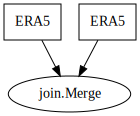

In [14]:
ERA5_data = edit.pipeline.load(
    Path(sfno.__file__).parent/'configs/Data/ERA5.yaml'
)
ERA5_data

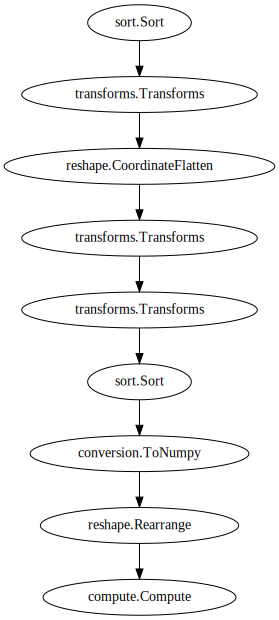

In [15]:
ERA5_pipeline = edit.pipeline.load(
    Path(sfno.__file__).parent/'configs/Pipeline/ERA5.yaml'
)
ERA5_pipeline

With those pipelines loaded, they can be combined into one massive pipeline, ready to get data.

In [16]:
SFNO_ERA5 = ERA5_data + ERA5_pipeline

In [17]:
SFNO_ERA5['2000-01-01T00'].shape

(1, 73, 721, 1440)

Yay, the pipeline is configured, and ready to go

(1 time step, 73 variables, lat, lon)

Therotically, we could pass a sample to the SFNO model, but as it is not yet a `torch.Tensor` and not on the `gpu`, pytorch will get mad. So there are a few more things to do.

So we shall use some of `edit.training` to build a scaffolding around it.

Firstly, wrapping the model within a `edit.training.lightning Wrapper` as this model uses `pytorch lightning`

In [18]:
edit.training.wrapper.lightning.Predict?

Init signature:
edit.training.wrapper.lightning.Predict(
    model: 'L.LightningModule',
    data: 'dict[str, Pipeline | str | tuple[Pipeline, ...]] | tuple[Pipeline | str, ...] | str | Pipeline | PipelineLightningDataModule',
    trainer_kwargs: 'dict[str, Any] | None' = None,
    **kwargs,
)
Docstring:      Pytorch Lightning ModelWrapper with prediction enabled.
Init docstring:
Lightning Prediction Wrapper

Allows for prediction with a pytorch lightning model upon `edit` data.

Args:
    model (L.LightningModule): 
        Lightning Model to use for prediction.
    data (dict[str, Pipeline | str | tuple[Pipeline, ...]] | tuple[Pipeline | str , ...] | str | Pipeline | PipelineLightningDataModule): 
        Pipeline to use to get data. Will be converted into a `PipelineLightningDataModule`.
    trainer_kwargs (dict[str, Any] | None, optional): 
        Kwargs to provide to Lightning Trainer. Defaults to None.
File:           /g/data/eu56/hc7988/Projects/EDIT/training/src/edit/training/

This wrapper takes in the base model, and the data we are going to use with it.

It can handle a simple `Pipeline`, dict, or tuple, with the data being passed to the model in the same form.

In [19]:
sfno_wrapped = edit.training.wrapper.lightning.Predict(
    model = sfno_model, 
    data = SFNO_ERA5
)
sfno_wrapped

LightingPrediction
	Initialisation                 Pytorch Lightning ModelWrapper with prediction enabled.
	trainer_kwargs                 
	pipelines                      
	splits

Now with a wrapped model, we can finally get into the prediction controller. 

As SFNO is a simple model with `inputs = outputs + 6 hours`, the simple autorecurrent predictor can be used.

These predictors allow for automated prediction, and reversing of the operations applied to prepare the data for the model, operations like normalisation, datatype conversion, etc....

This can be done through `pipeline.undo`. See the pipeline notebooks for more information.

In [20]:
edit.training.predict.TimeSeriesAutoRecurrent?

Init signature:
edit.training.predict.TimeSeriesAutoRecurrent(
    model: 'ModelWrapper',
    reverse_pipeline: 'Pipeline | int | str | None' = None,
    *,
    fix_time_dim: 'bool' = True,
    interval: 'int | str | TimeDelta' = 1,
    time_dim: 'str' = 'time',
    combine: "Optional[Literal['stack', 'concat']]" = 'concat',
    combine_axis: 'int' = 0,
)
Docstring:      AutoRecurrent temporal predictions.
Init docstring:
Predict with a `model` a time series.


`combine` and `combine_axis` can be used to modify how timesteps are combined,
if model predictions have a leading time dim, use `concat`, or if time dim at 2nd axis,
set `combine_axis = 1`.
If no time dim included, set `combine` to `stack`.

If data must be reversed before being combined, set `combine = None`.
Will be undone, and `xr.combine_by_coords` used.

## Warning:
    The pipeline that is used to undo the predictions, if `combine` must allow a change in the time dimension,
    i.e. no squish's or expand's on that dim.

A

This will use the model to run a prediction, and then feed the outputs back in as inputs.

But we must tell it that the model predicts at 6 hourly intervals.

In [21]:
sfno_wrapped

LightingPrediction
	Initialisation                 Pytorch Lightning ModelWrapper with prediction enabled.
	trainer_kwargs                 
	pipelines                      
	splits

In [22]:
predictor = edit.training.predict.TimeSeriesAutoRecurrent(
    model = sfno_wrapped, 
    interval = '6 hours'
)
predictor

TimeSeriesAutoRecurrent
	Initialisation                 AutoRecurrent temporal predictions.
		 combine                        'concat'
		 combine_axis                   0
		 fix_time_dim                   True
		 interval                       '6 hours'
		 model                          {}
		 reverse_pipeline               None
		 time_dim                       'time'

Now that we have the predictor, we can run a prediction by calling `.recurrent` and passing in an index.

In [ ]:
# predictor.recurrent('2000-01-01T00')

Now, finally we can run some predictions, and to get it in an `MLDataIndex`, the remaining configuration is needed.
We need to tell it how to generate data, and where to save it.

This index looks like any other `edit.data.Index` and can be used just like you would `ERA5`.

In [23]:
edit.training.MLDataIndex(
    predictor, 
    cache = 'temp', # Save in temp directory
    data_interval = (6, 'hours'),  # Data output time interval
    prediction_function = 'recurrent', # Which function to use to generate data
    prediction_config = dict(          # Kwargs for prediction_funcitn
        steps = 4, # Model steps forward 
        verbose = True,
        fake_batch_dim = True,
    )
)

MLDataIndex
	Initialisation                 `edit.training` DataIndex
		 cache                          'temp'
		 data_attributes                None
		 data_interval                  TimeDelta((6, 'hours'))
		 offsetInterval                 False
		 override                       False
		 post_transforms                None
		 prediction_config              {}
		 prediction_function            'recurrent'
		 wrapper                        {}
	Transforms                     
		 StandardCoordinateNames        {}